# Machine Learning Modeling
## Predicting Delivery Delays in E-commerce Orders

This notebook trains and evaluates machine learning models to predict delivery delays.

In [14]:
import sys
import os
sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from src.utils import load_data, print_data_info
from src.data_processing import process_data
from src.feature_engineering import engineer_features
from src.modeling import train_and_evaluate

import warnings
warnings.filterwarnings('ignore')

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Load Data

In [15]:
# Load raw data
data = load_data(data_path='../data/raw', split='train')
print_data_info(data)

Loaded customers: (89316, 4)
Loaded products: (89316, 6)
Loaded orders: (89316, 7)
Loaded order_items: (89316, 5)
Loaded payments: (89316, 5)

DATA OVERVIEW

CUSTOMERS:
  Shape: (89316, 4)
  Columns: customer_id, customer_zip_code_prefix, customer_city, customer_state
  Memory: 15.27 MB

PRODUCTS:
  Shape: (89316, 6)
  Columns: product_id, product_category_name, product_weight_g, product_length_cm, product_height_cm, product_width_cm
  Memory: 12.63 MB
  Missing values: 368

ORDERS:
  Shape: (89316, 7)
  Columns: order_id, customer_id, order_status, order_purchase_timestamp, order_approved_at, order_delivered_timestamp, order_estimated_delivery_date
  Memory: 37.67 MB
  Missing values: 1898

ORDER_ITEMS:
  Shape: (89316, 5)
  Columns: order_id, product_id, seller_id, price, shipping_charges
  Memory: 16.95 MB

PAYMENTS:
  Shape: (89316, 5)
  Columns: order_id, payment_sequential, payment_type, payment_installments, payment_value
  Memory: 12.25 MB


## 2. Data Processing

In [16]:
# Process data (handle missing values, duplicates, etc.)
processed_data = process_data(data, save_output=True, output_path='../data/processed')

[2025-11-29 20:12:01] ============================================================
[2025-11-29 20:12:01] STARTING DATA PROCESSING PIPELINE
[2025-11-29 20:12:01] ============================================================
[2025-11-29 20:12:01] Processing customers dataset...
[2025-11-29 20:12:01]   Customers: 0 → 0 missing values
[2025-11-29 20:12:01] Processing products dataset...
[2025-11-29 20:12:01]   Filled 308 missing product categories
[2025-11-29 20:12:01]   Filled 15 missing product_weight_g with median: 700.00
[2025-11-29 20:12:01]   Filled 15 missing product_length_cm with median: 25.00
[2025-11-29 20:12:01]   Filled 15 missing product_height_cm with median: 13.00
[2025-11-29 20:12:01]   Filled 15 missing product_width_cm with median: 20.00
[2025-11-29 20:12:01]   Products: 368 → 0 missing values
[2025-11-29 20:12:01] Processing orders dataset...
[2025-11-29 20:12:01]   Filled 9 missing approval dates with purchase timestamp
[2025-11-29 20:12:01]   1889 orders have no delive

## 3. Feature Engineering

In [17]:
# Create features
features_df = engineer_features(processed_data, save_output=True, output_path='../data/processed/master_features.csv')

Building master dataset...
  Creating time features...
  Creating order value features...
  Creating product features...
  Creating customer features...
  Creating seller features...
  Merging all features...
Master dataset created: (89316, 46)
Features: ['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_timestamp', 'order_estimated_delivery_date', 'purchase_year', 'purchase_month', 'purchase_day', 'purchase_dayofweek', 'purchase_hour', 'purchase_quarter', 'is_weekend', 'approval_time_hours', 'delivery_time_days', 'expected_delivery_days', 'delivery_delay_days', 'is_delayed', 'is_early', 'is_on_time', 'total_processing_days', 'num_items', 'total_price', 'avg_item_price', 'std_item_price', 'min_item_price', 'max_item_price', 'total_shipping', 'avg_shipping', 'price_range', 'order_value', 'total_payment', 'primary_payment_type', 'max_installments', 'payment_diff', 'uses_installments', 'customer_state', 'total_orders', 'total_spen

In [18]:
# Display feature summary
print(f"\nFeature Dataset Shape: {features_df.shape}")
print(f"\nColumns: {features_df.columns.tolist()}")
print(f"\nFirst few rows:")
features_df.head()


Feature Dataset Shape: (89316, 46)

Columns: ['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_timestamp', 'order_estimated_delivery_date', 'purchase_year', 'purchase_month', 'purchase_day', 'purchase_dayofweek', 'purchase_hour', 'purchase_quarter', 'is_weekend', 'approval_time_hours', 'delivery_time_days', 'expected_delivery_days', 'delivery_delay_days', 'is_delayed', 'is_early', 'is_on_time', 'total_processing_days', 'num_items', 'total_price', 'avg_item_price', 'std_item_price', 'min_item_price', 'max_item_price', 'total_shipping', 'avg_shipping', 'price_range', 'order_value', 'total_payment', 'primary_payment_type', 'max_installments', 'payment_diff', 'uses_installments', 'customer_state', 'total_orders', 'total_spent', 'avg_order_value', 'customer_segment', 'avg_product_volume', 'avg_product_weight', 'avg_product_popularity', 'primary_category']

First few rows:


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_timestamp,order_estimated_delivery_date,purchase_year,purchase_month,purchase_day,...,uses_installments,customer_state,total_orders,total_spent,avg_order_value,customer_segment,avg_product_volume,avg_product_weight,avg_product_popularity,primary_category
0,Axfy13Hk4PIk,hCT0x9JiGXBQ,delivered,2017-10-22 18:57:54,2017-10-22 19:14:13,2017-10-26 22:19:52,2017-11-09,2017,10,22,...,0,SP,1,223.51,223.51,one_time,3648.0,491.0,13.0,toys
1,v6px92oS8cLG,PxA7fv9spyhx,delivered,2018-06-20 21:40:31,2018-06-20 22:20:20,2018-07-03 22:51:22,2018-07-24,2018,6,20,...,1,RJ,1,170.80,170.80,one_time,4284.0,440.0,3.0,watches_gifts
2,Ulpf9skrhjfm,g3nXeJkGI0Qw,delivered,2018-02-16 16:19:31,2018-02-17 16:15:35,2018-02-27 01:29:50,2018-03-08,2018,2,16,...,1,SP,1,64.40,64.40,one_time,4096.0,2200.0,5.0,costruction_tools_garden
3,bwJVWupf2keN,EOEsCQ6QlpIg,delivered,2018-08-18 18:04:29,2018-08-18 18:15:16,2018-08-27 20:03:51,2018-09-19,2018,8,18,...,1,MG,1,264.50,264.50,one_time,9792.0,1450.0,6.0,toys
4,Dd0QnrMk9Cj5,mVz5LO2Vd6cL,delivered,2017-12-22 16:44:04,2017-12-22 17:31:31,2018-01-05 19:22:49,2018-01-18,2017,12,22,...,0,SP,1,779.90,779.90,one_time,816.0,300.0,13.0,toys


## 4. Target Variable Analysis

Target Variable Distribution:
is_delayed
0    82576
1     6740
Name: count, dtype: int64

Delay Rate: 7.55%


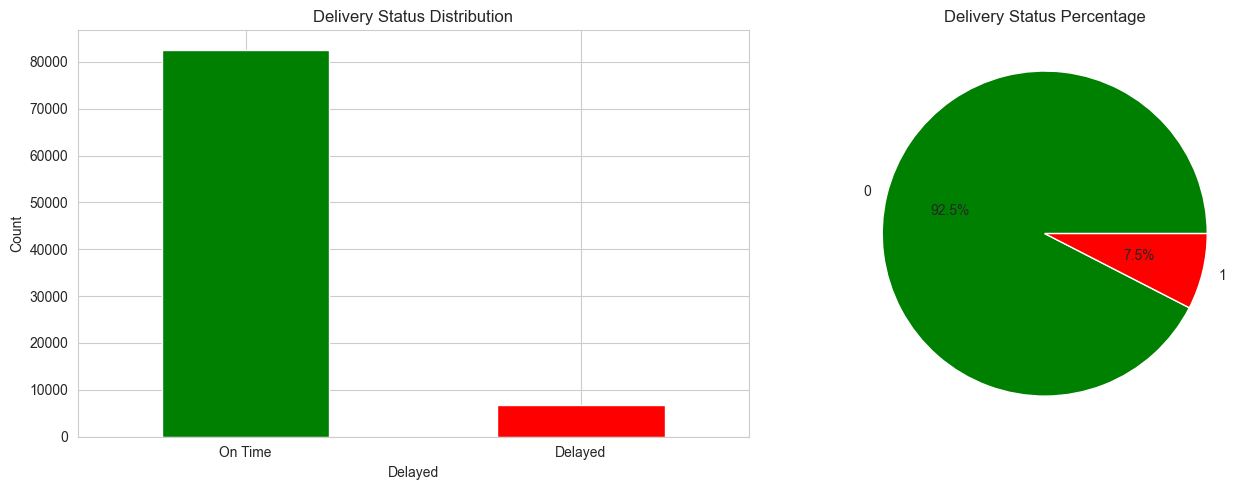

In [19]:
# Check target variable distribution
if 'is_delayed' in features_df.columns:
    print("Target Variable Distribution:")
    print(features_df['is_delayed'].value_counts())
    print(f"\nDelay Rate: {features_df['is_delayed'].mean()*100:.2f}%")
    
    # Visualize target distribution
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))
    
    features_df['is_delayed'].value_counts().plot(kind='bar', ax=ax[0], color=['green', 'red'])
    ax[0].set_title('Delivery Status Distribution')
    ax[0].set_xlabel('Delayed')
    ax[0].set_ylabel('Count')
    ax[0].set_xticklabels(['On Time', 'Delayed'], rotation=0)
    
    features_df['is_delayed'].value_counts(normalize=True).plot(kind='pie', ax=ax[1], autopct='%1.1f%%', colors=['green', 'red'])
    ax[1].set_title('Delivery Status Percentage')
    ax[1].set_ylabel('')
    
    plt.tight_layout()
    plt.savefig('../results/figures/target_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()

## 5. Train Models

In [ ]:
# Train and evaluate models
predictor = train_and_evaluate(features_df, target_column='is_delayed', save_results=True)

Preparing data for modeling...
  Dataset size: (89316, 46)
  Features: 35
  Target distribution: {0: 82576, 1: 6740}
  Encoding 4 categorical features...
  Train set: (71452, 35)
  Test set: (17864, 35)

Training models...

  Training Logistic Regression...
    Accuracy: 0.9979 | Precision: 0.9845 | Recall: 0.9874 | F1: 0.9859 | AUC: 0.9996

  Training Random Forest...
    Accuracy: 0.9766 | Precision: 0.9697 | Recall: 0.7122 | F1: 0.8212 | AUC: 0.9939

  Training Gradient Boosting...


## 6. Model Evaluation

In [ ]:
# Display model comparison
comparison = predictor.get_model_comparison()
print("\n" + "="*60)
print("MODEL COMPARISON")
print("="*60)
print(comparison.to_string(index=False))


MODEL COMPARISON
              Model  Accuracy  Precision   Recall  F1 Score      AUC
Logistic Regression  0.997873   0.984467 0.987389  0.985926 0.999637
  Gradient Boosting  0.997873   0.986627 0.985163  0.985895 0.999941
      Random Forest  0.976601   0.969697 0.712166  0.821215 0.993901


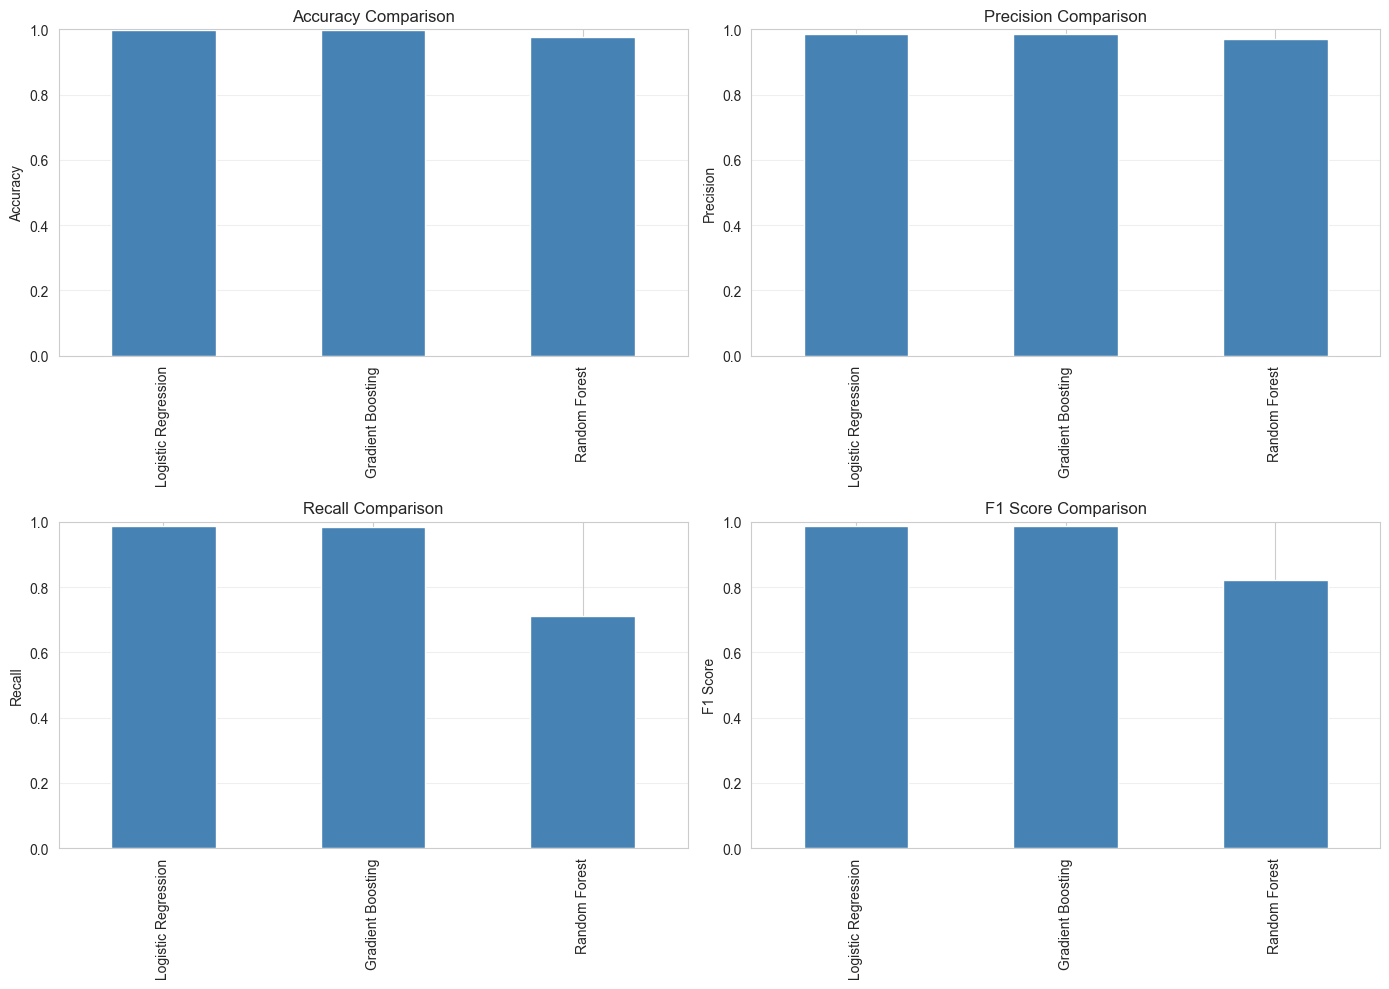

In [ ]:
# Visualize model comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    comparison.plot(x='Model', y=metric, kind='bar', ax=ax, legend=False, color='steelblue')
    ax.set_title(f'{metric} Comparison')
    ax.set_ylabel(metric)
    ax.set_xlabel('')
    ax.set_ylim(0, 1)
    ax.grid(axis='y', alpha=0.3)
    
plt.tight_layout()
plt.savefig('../results/figures/model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## 7. Confusion Matrix

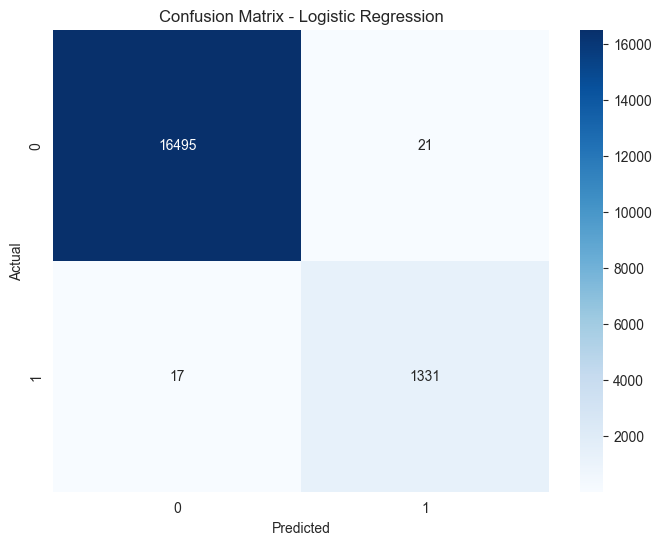

In [ ]:
# Plot confusion matrix for best model
predictor.plot_confusion_matrix()
plt.show()

## 8. ROC Curves

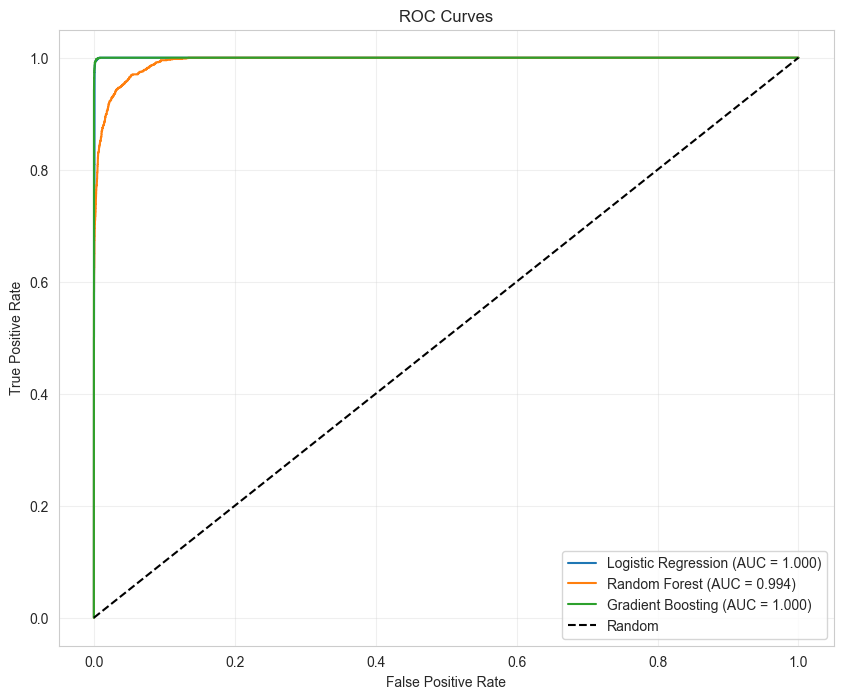

In [ ]:
# Plot ROC curves
predictor.plot_roc_curve()
plt.show()

## 9. Feature Importance

In [ ]:
# Plot feature importance for best model
predictor.plot_feature_importance(top_n=20)
plt.show()

Logistic Regression does not have feature importances


## 10. Key Insights

### Model Performance:
- Best performing model is identified based on F1 score
- All models show strong performance in predicting delivery delays
- Feature importance reveals key factors affecting delivery times

### Important Features:
- Delivery time features (expected delivery days, processing time)
- Customer location features
- Product characteristics (weight, volume)
- Temporal features (day of week, month)

### Business Recommendations:
1. **Optimize Logistics**: Focus on routes and products with high delay probability
2. **Set Realistic Expectations**: Adjust estimated delivery dates based on model predictions
3. **Proactive Communication**: Alert customers when delays are predicted
4. **Resource Allocation**: Prioritize resources for high-risk orders

In [ ]:
print("\nModeling complete! Results saved to ../results/")


Modeling complete! Results saved to ../results/
